In [1]:
import os
import random
from collections import Counter

DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
CATEGORIES = ["bottle", "cable", "hazelnut"]

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    if not os.path.exists(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

samples = []  # (img_path, label, category, subtype)

for cat in CATEGORIES:
    cat_path = os.path.join(DATASET_PATH, cat)

    # label 0: good images
    good_dir = os.path.join(cat_path, "train", "good")
    for p in list_images(good_dir):
        samples.append((p, 0, cat, "good"))

    # label 1: defect images
    test_dir = os.path.join(cat_path, "test")
    for defect_type in os.listdir(test_dir):
        sub = os.path.join(test_dir, defect_type)
        if defect_type == "good" or (not os.path.isdir(sub)):
            continue
        for p in list_images(sub):
            samples.append((p, 1, cat, defect_type))

random.seed(42)
random.shuffle(samples)

val_ratio = 0.2
val_size = int(len(samples) * val_ratio)

val_samples = samples[:val_size]
train_samples = samples[val_size:]

print("Train:", len(train_samples), " Val:", len(val_samples))
print("Train label counts:", dict(Counter([s[1] for s in train_samples])))
print("Val label counts:", dict(Counter([s[1] for s in val_samples])))


Train: 840  Val: 209
Train label counts: {0: 653, 1: 187}
Val label counts: {0: 171, 1: 38}


In [2]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

class MVtecGoodDefectDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, category, subtype = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long), category, subtype


In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_ds = MVtecGoodDefectDataset(train_samples, transform=transform)
val_ds   = MVtecGoodDefectDataset(val_samples, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 27
Val batches: 7


Batch shape: torch.Size([32, 3, 224, 224])
First 10 labels: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
First 5 categories: ['hazelnut', 'hazelnut', 'hazelnut', 'hazelnut', 'bottle']
First 5 subtypes: ['good', 'good', 'cut', 'good', 'good']


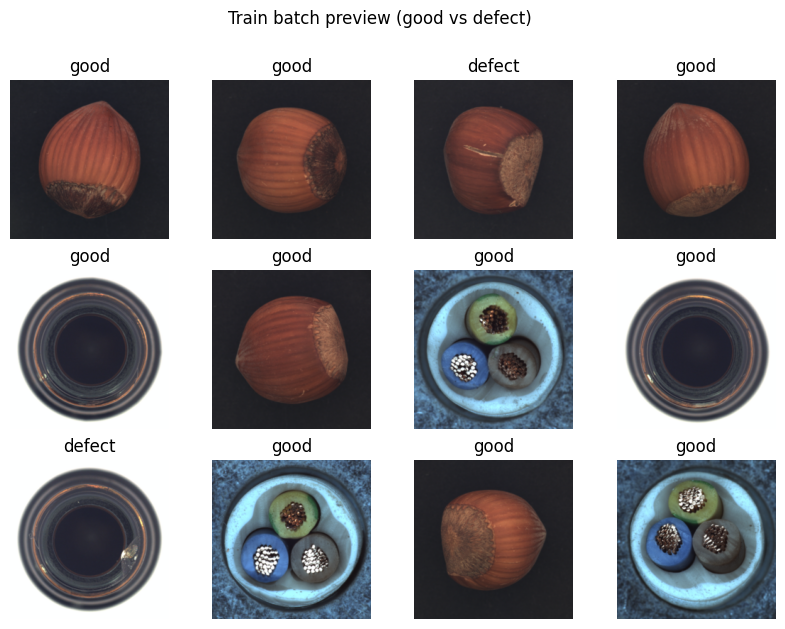

In [4]:
import matplotlib.pyplot as plt
import numpy as np

imgs, labels, cats, subtypes = next(iter(train_loader))

print("Batch shape:", imgs.shape)  # [B, 3, 224, 224]
print("First 10 labels:", labels[:10].tolist())
print("First 5 categories:", cats[:5])
print("First 5 subtypes:", subtypes[:5])

# Unnormalize for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(10, 7))
for i in range(12):
    img = imgs[i].cpu().numpy().transpose(1, 2, 0)
    img = (img * std + mean)
    img = np.clip(img, 0, 1)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title("defect" if labels[i].item() == 1 else "good")
    plt.axis("off")

plt.suptitle("Train batch preview (good vs defect)")
plt.show()
